# BilbyAnalysis.ipynb

Maria Okounkova (mokounkova@flatironinstitute.org)

### Notebook for the analysis of Bilby runs, including corner plots and evidences

### Imports

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
from astropy import constants as const
from math import pi
import lal
import lalsimulation as lalsim
import pesummary
from pesummary.io import read

### Functions for injection values, Bayes factors, evidences, etc

In [6]:
# LabelDict = {'chirp_mass' : r"$\mathcal{M} [M_\odot]$", 'mass_ratio' : r"$q$", \
#              'a_1' : r"$a_1$", 'a_2' : r"$a_2$", 'luminosity_distance' : r"$d_L$ [mpc]", \
#             'dec' : 'dec', 'ra' : 'ra', 'theta_jn' : r"$\theta_{jn}$", 'tilt_1' : r"$\theta_1$", \
#             'tilt_2' : r"$\theta_2$", 'psi' : r"$\psi$", 'phase' : r'$\Delta \phi$', 'chi_eff' : r'$\chi_\mathrm{eff}$', \
#             'm_1' : r"$m_1$", 'm_2' : r"$m_2$"}
    
def GetTruthDict(p):
    """ Return a dictionary of truth values for corner plots from the parameters.json file 
        corresponding to the injected parameters, where p is the path to the file """
    TruthDict = {}
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    TruthDict['chirp_mass'] = params['chirp_mass']
    TruthDict['mass_ratio'] = params['mass_ratio']
    TruthDict['mass'] = params['mass']
    TruthDict['luminosity_distance'] = params['dist_mpc']
    TruthDict['a_1'] = np.abs(params['a_1'][2]) ## assumes aligned spin for now
    TruthDict['a_2'] = np.abs(params['a_2'][2])
    TruthDict['dec'] = params['dec']
    TruthDict['ra'] = params['ra']
    TruthDict['theta_jn'] = params['theta']
    TruthDict['tilt_1'] = 0.0
    TruthDict['tilt_2'] = np.pi
    TruthDict['phase'] = params['phi']
    TruthDict['psi'] = params['pol'] 
    TruthDict['m_1'] = params['m_1']
    TruthDict['m_2'] = params['m_2']
    TruthDict['chi_eff'] = params['chi_eff']
    TruthDict['chi_p'] = 0.0 ## Since this is a non-precessing run
    f.close()
    return TruthDict

def Evidence(p):
    """ Return the log evidence for a given bilby run
        located in directory p """
    f = open(p + '/outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_evidence']

def NoiseEvidence(p):
    """ Return the log noise evidence for a given bilby run
        located in directory p """
    f = open(p + '/outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_noise_evidence']

def EvidenceErr(p):
    """ Return the error on the log evidence for a given bilby run 
        located in directory p """
    f = open(p + '/outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_evidence_err']

def BayesFactor(p):
    """ Return the log Bayes factor for a given bilby run 
        located in directory p """
    f = open(p + '/outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_bayes_factor']

def EvidenceAndBayes(p):
    """ Return the log Bayes factor, log evidence, and log evidence error
        for a given bilby run located in directory p """
    f = open(p + '/outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_bayes_factor'], data['log_evidence'], data['log_evidence_err']
    
def EvidenceAndBayesArray(p_array):
    """ Return the log Bayes factor, log evidence, and log evidence error
        for a set of bilby runs located in directories given in p_array """
    bfs = []
    evs = []
    ev_errs = []
    for p in p_array:
        bf, ev, ev_err = EvidenceAndBayes(p)
        print(f, bf)
        bfs.append(bf)
        evs.append(ev)
        ev_errs.append(ev_err)
    return bfs, evs, ev_errs

# def GetPosterior(p, quantity):
#     """ Return the posterior for a given bilby run
#         for a given quantity, such as mass_ratio, 
#         chirp_mass, a_1, a_2, etc"""
#     print("Getting parameter...", quantity)
#     f = open(p + '/fast_tutorial_result.json')
#     data = json.load(f)
#     vals = data['posterior']['content'][quantity]
#     f.close()
#     vals = np.array(vals)
#     return vals

# def ComputeChieff(theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2, m1, m2):
#     f_ref = 25.0
#     phi_orb = 0.0
#     """ Change spin convention for Bilby / lal quantities to surrogate model quantities """
#     iota, S1x, S1y, S1z, S2x, S2y, S2z = lalsim.SimInspiralTransformPrecessingNewInitialConditions(
#                                              theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2,
#                                              m1*lal.MSUN_SI, m2*lal.MSUN_SI, f_ref, phi_orb)
#     chi_eff = (S1z/m1 + S2z/m2)/(m1 + m2)
#     return chi_eff

def EllinKm(ell_string, mass):
    """ For dCS parameters, convert from the string corresponding
        to the dimensionless ell value (like `0p0`) to a value
        in kilometers (like 0.0 [km]) """
    ell = float(ell_string.replace('p', '.'))
    mass_msun = mass * const.M_sun
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000
    return phys_ell_km.value

def SummaryPageFile(name):
    return "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/" + name + \
        "/summary_pages/samples/posterior_samples.h5"

### One dimensional histograms

2021-12-01  12:43:08 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2021-12-01  12:43:08 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2021-12-01  12:43:08 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default


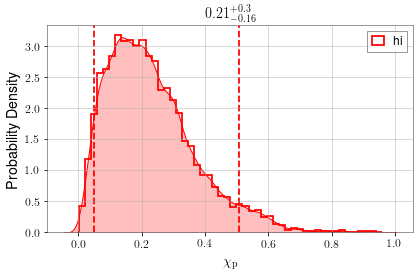

In [7]:
def Histogram():

    file_name = SummaryPageFile('PHENOM_dCS_0p0_75')
    data = read(file_name)
    samples_dict = data.samples_dict
    posterior_samples = samples_dict["summary_pages"]
    
    fig = plt.figure()
    posterior_samples.plot("chi_p", type="hist", kde=True, color = 'red', label = 'hi', fig = fig)
    #posterior_samples.plot("chi_p", type="hist", kde=True, color = 'blue', label = 'hi2', fig = fig)
    plt.legend()
    plt.show()
    
Histogram()


2021-12-01  12:45:59 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2021-12-01  12:45:59 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2021-12-01  12:45:59 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2021-12-01  12:46:02 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2021-12-01  12:46:02 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2021-12-01  12:46:02 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2021-12-01  12:46:07 PESummary WARNING : Could not find f_final in input fil

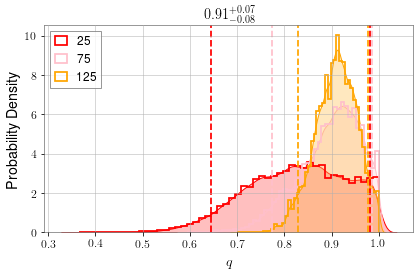

In [11]:
def Histograms():

    fig = plt.figure()
    for SNR, c in zip(['25', '75', '125'], ['red', 'pink', 'orange']):

        file_name = SummaryPageFile('PHENOM_dCS_0p0_' + SNR)
        data = read(file_name)
        samples_dict = data.samples_dict
        posterior_samples = samples_dict["summary_pages"]
    
    
        posterior_samples.plot("mass_ratio", type="hist", kde=True, \
                               color = c, label = SNR, fig = fig)
    
    plt.legend()
    plt.show()
    
Histograms()

2021-12-01  12:50:52 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2021-12-01  12:50:52 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2021-12-01  12:50:52 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2021-12-01  12:50:55 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2021-12-01  12:50:55 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2021-12-01  12:50:55 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2021-12-01  12:50:59 PESummary WARNING : Could not find f_final in input fil

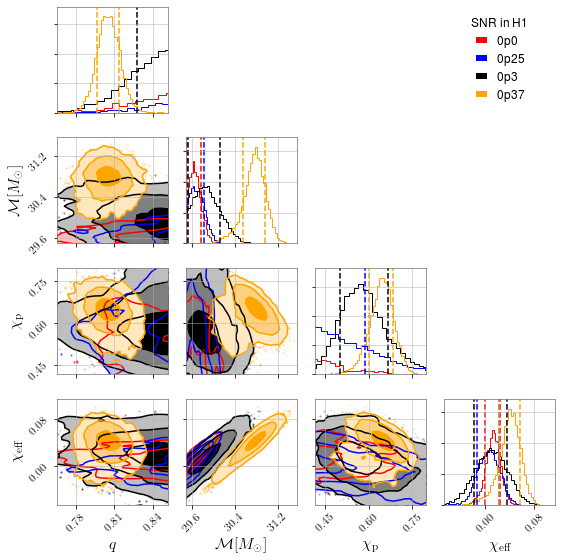

In [15]:
def CornerPlot():
    """ Make a corner plot of Bilby runs on GR injections with various SNRs"""

    base = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'
    parameters = ['mass_ratio', 'chirp_mass', 'chi_eff', 'chi_p']
    dim = len(parameters) 

    snr_values = ["25", "75", "125"] 
    ps = [base + 'PHENOM_dCS_0p0_' + snr for snr in snr_values]
    
    ell_values = ['0p0', '0p25', '0p3', '0p37']
    SNR = '125'
    ps = [base + 'PHENOM_dCS_' + ell + '_' + SNR for ell in ell_values]

    labels = ell_values
    
    TruthDict = GetTruthDict(ps[0])
    truths = [TruthDict[q] for q in parameters]
    mass = TruthDict['mass']
    
    fig, ax_arr = plt.subplots(dim, dim, figsize = (8,8))
    handles = []
    
    colors = ['red', 'blue', 'black', 'orange']
    #cmap = 'magma'
    #colors = sns.color_palette(cmap, n_colors=len(ps) + 1)
    
    for p, label, color in zip(ps, labels, colors):
        
        file_name = p + "/summary_pages/samples/posterior_samples.h5"
        data = read(file_name)
        samples_dict = data.samples_dict
        posterior_samples = samples_dict["summary_pages"]

        posterior_samples.plot(type="corner",
                             parameters=parameters, fig = fig, color = color, inj_value = truths, label = label)
        
        ## Dealing with the legend
        l = ax_arr[0][dim-1].plot([0,0], [0,0], label=label, color = color)
        #l = ax_arr[0][dim-1].plot(x, y, label='%.1f' % EllinKm(ell, mass), color = color)
        handles.append(l[0])

    ## Plot the injected values myself
    
    #plt.legend()
    legend = ax_arr[0][dim-1].legend(handles=handles, frameon=False, title = r'SNR in H1', loc = 'upper center')
    #legend = ax_arr[0][dim-1].legend(handles=handles, frameon=False, title = r'$\ell$ [km]', loc = 'upper center')
    plt.setp(legend.get_title(),fontsize=12)
    #for ax in fig.get_axes():
    #    ax.tick_params(axis='both', labelsize=12, length=6)
        
    plt.tight_layout()
    #plt.savefig('SNRCornerPlot.pdf')
    #plt.savefig('dCSCorner_' + SNR + '.pdf')
    plt.show()
    
CornerPlot()  

### Plot Bayes factors as a function of SNR Bilby runs

0p0 25 280.0459045496858
0p0 75 2760.2733739864034
0p0 125 7746.3035438938105
0p2 25 279.63345545165856
0p2 75 2762.5845831503757
0p2 125 7749.456289761069
0p25 25 279.9757107997255
0p25 75 2765.675257349214
0p25 125 7759.257459985336
0p3 25 280.6494570872661
0p3 75 2773.3344230484677
0p3 125 7785.677702597705
0p35 25 278.91431007661976
0p35 75 2788.1150187912876
0p35 125 7840.596476072983
0p37 25 277.7762085942666
0p37 75 2796.3955493968974
0p37 125 7862.973818772832


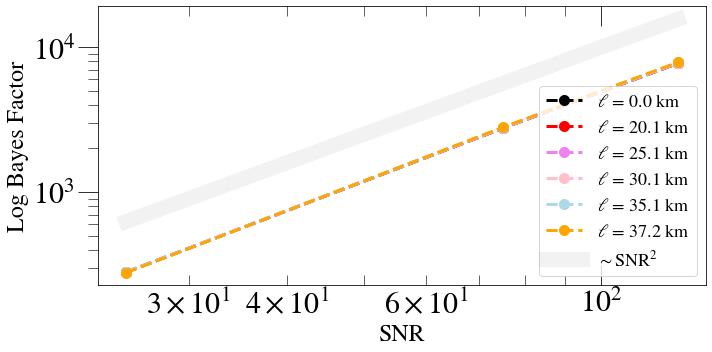

In [24]:
def PlotBayesSNR():
    """ Plot Bayes factors for various dCS parameters as a function of SNR """
    
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/"
    mass = 68
    
    ells = ["0p0","0p2", "0p25", "0p3", "0p35", "0p37"]
    colors = ['black', 'red', 'violet', 'pink', 'lightblue', 'orange']
    snrs = [25, 75, 125]
    
    plt.figure(figsize=(10, 5))
    
    for ell, color in zip(ells, colors):

        bayes_arr = []

        for snr in snrs:

            p = base_dir + "AllSearch_dCS_" + ell + "_" + str(snr)
            bayes = BayesFactor(p)
            print(ell, snr, bayes)
            bayes_arr.append(bayes)

        plt.plot(snrs, bayes_arr, '--o', color = color, label = "$\ell$ = %.1f km" % EllinKm(ell, mass), markersize = 10)
        
    ## Add in 1/SNR^2 curve 
    SNRS = np.linspace(snrs[0], snrs[-1], 100)
    snr_curve = SNRS**2.0
    plt.plot(SNRS, snr_curve, color='gray', label = r'$\sim \mathrm{SNR}^{2}$', alpha = 0.1, lw = 15.0)

    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Log Bayes Factor')
    plt.xlabel('SNR')
    plt.tight_layout()
    plt.savefig('BayesSNR.pdf')
    plt.show()
    
PlotBayesSNR()

### Plot Bayes factors as a function of $\ell$ for Bilby Runs

0p0
0p2
0p25
0p3
0p35
0p37


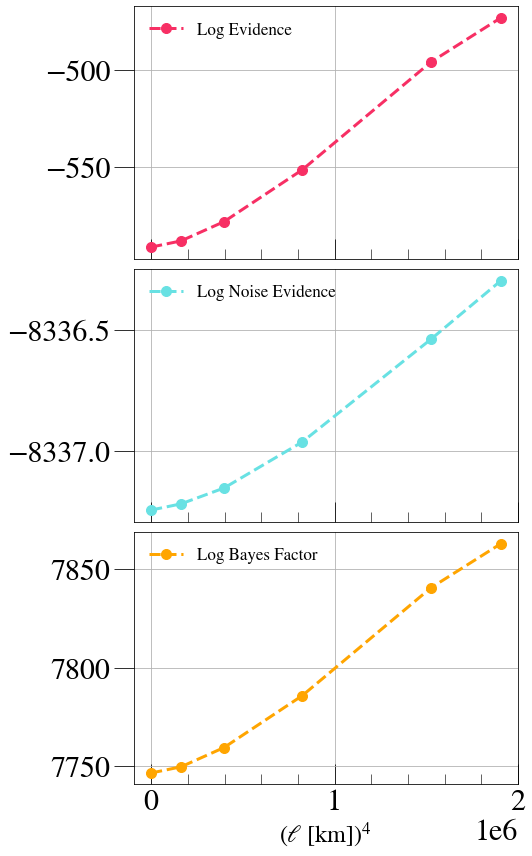

In [28]:
def PlotBayesEll():

    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/"
    mass = 68

    ells = ["0p0", "0p2", "0p25", "0p3", "0p35", "0p37"]
    ell_vals = [EllinKm(ell, mass) for ell in ells]
    snr = 125

    bayes_arr = []
    evidence_arr = []
    noise_evidence_arr = []

    for ell in ells:

        print(ell)
        p = base_dir + "AllSearch_dCS_" + ell + "_" + str(snr)
        bayes_arr.append(BayesFactor(p))
        evidence_arr.append(Evidence(p))
        noise_evidence_arr.append(NoiseEvidence(p))
        
    fig, axes = plt.subplots(3, figsize=(7.5,12), sharex = True)

    axes[0].plot(np.array(ell_vals)**4, evidence_arr, '--o', color = '#f72f64', label = 'Log Evidence', markersize = 10)
    axes[1].plot(np.array(ell_vals)**4, noise_evidence_arr, '--o', color = '#68e1e3', label = 'Log Noise Evidence', markersize = 10)
    axes[2].plot(np.array(ell_vals)**4, bayes_arr, '--o', color = 'orange', label = 'Log Bayes Factor', markersize = 10)

    for ax in axes:
        ax.legend(fontsize=17, loc = 'upper left', frameon=False)
        ax.tick_params(axis='x', which='both', bottom=True, top=False) 
        ax.grid()

    plt.xlabel(r'($\ell$ [km])${}^4$')
    plt.tight_layout()
    plt.savefig('BayesEll.pdf')
    plt.show()
    
PlotBayesEll()

### Understanding Bilby minimum frequency values

Bilby parameter estimation with the surrogate model requires specifying a minimum frequency f_sur_min, and this minuimum frequency must be greater than the minimum frequency of the waveform injection. If this criterion is not met (ie we ask for a lower f_sur_min than the injection f_injection_min), then Bilby throws an error saying that the requested minimum frequency, f_bilby_requested, is < f_injection_min. However, in practice, the f_bilby_requested reported by Bilby error messages is NOT equal to f_sur_min, which doesn't make sense. However, we can explore the relationship between these two quantities using the surrogate injection below:

for configuration:

mass_ratio = 1.0
chirp_mass = 20.0
a_1 = 0.99
a_2 = 0.99
tilt_1 = 0.0
tilt_2 = 3.14159265359
phi_12 = 0.0
phi_jl = 0.0


In [10]:
def BilbyMinimumFrequency():
    
    sur_fmin = [20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0]
    bil_fmin = [16.04293095, 16.69953829, 17.34314270, 17.97386363, 18.59182733, 19.19716692, 19.79002226, 20.37053975, \
              20.93887207, 21.49517785, 22.03962128, 22.57237175]
    ## Fit a relationship between the two
    fit = np.polyfit(sur_fmin, bil_fmin, 3)
    p = np.poly1d(fit)
    print(p)
    
    ## What the f_min should be for the run specified above
    fmin_should = 22.70617355 
    

    plt.figure(figsize=(8,8))

    plt.plot(sur_fmin, bil_fmin, '--o', color='red', label = 'values')
    plt.plot(sur_fmin, p(sur_fmin), label = 'quad fit', lw = 2.0, color = 'pink')

    plt.xlabel('Our requested minimum_frequency')
    plt.ylabel('Bilby reported requested fMin')

    plt.axhline(fmin_should, color='black', ls = '--', label = 'What Bilby says fMin should be')

    plt.legend()

    plt.show()

#BilbyMinimumFrequency()